# Overview and Notes

What are interesting scenarios for exploring correlations?
* Expression-dependency correlations for dependency genes that are druggable. For these, the expression correlates are informative for selection of sensitive cell lines/patients. In addition, causally related expression correlates are suggestive of possible resistance mechanisms or secondary targets for a drug combination.
* Dependency-dependency correlations for undruggable genes. For these, the correlates are suggestive of substitute targets, or combinations of targets. However, as combinations are considered the causal interpretation becomes more important.
* Expression-expression correlations. In this case one idea would be to explore the strength and sign of relationships from the data vs. assertions from curated databases/literature, particularly from perturbational experiments.
* Co-expression patterns. Another possibility is to discover patterns of relationships between genes, e.g. that expression of ubiquitin ligases is correlated with the expression of their targets.

Another interesting direction would be to use the information in the INDRA database to discover patterns of mechanistic relationships that predict correlations between dependencies of two genes, or between expression of a gene and dependency of another gene. The simplest possible application of this would be to look at pairwise relationships between two genes (could even extract from SIF), and test to see which types of relationships, and signs of relationships predicted, and amount of evidence predicted a) the sign of a correlation and b) the strength of the correlation.

If the matrix is made complete, i.e., if entries are included for having no known relationship, we may find that having no relationship is not predictive of a lack of a correlation.

Similarly, there will be many mechanistic relationships that yield detectable correlations.

One hypothesis that could be tested is whether downstream siblings were more likely to have large correlations to each other than with their ancestors, highlighting that correlations rarely pick up causal relations in this type of data.

Could do this with graph convolutional nets?

Another application would be to use the data to refine vague relationships extracted from text, or to address issues with assembly, a la distant supervision.

Another direction would be to cluster the correlation graph to find likely intermediates.

Or, to use the redundancy of certain gene families to explain why certain correlations do *not* show up, i.e., the gene knockout has no effect because it has a redundant copy.

# Preliminaries

In [1]:
import pickle
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
from indra.databases import hgnc_client
from indra.tools import assemble_corpus as ac

## Load transcript and dependency data and compute correlations


Key variables/functions:
* `ccle_df`. CCLE expression data, DataFrame.
* `crispr_df`. DepMap CRISPR gene effect (dependency) data, DataFrame.
* `crispr_corr`
* `crispr_z`
* `rnai_df`. DepMap combined RNAi data, DataFrame.
* `rna_corr`
* `rnai_z`
* `dep_z`
* `dep_df`. CRISPR and RNAi data combined as averaged z-scores, DataFrame.
* `dep_corr`. Correlation matrix between dep-dep, dep-expr, and expr-expr (though expr-expr correlations are only defined in this matrix for the genes also included in the dependency data).

### Cell line metadata

Load the cell line metadata which includes mappings between cell line identifiers used by different datasets.

In [2]:
cell_line_df = pd.read_csv('data/DepMap-2019q1-celllines_v2.csv')

In [3]:
cell_line_map = cell_line_df[['DepMap_ID', 'CCLE_Name']]
cell_line_map.set_index('CCLE_Name', inplace=True)
cell_line_map.head()

,DepMap_ID
CCLE_Name,
NIHOVCAR3_OVARY,ACH-000001
HL60_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,ACH-000002
CACO2_LARGE_INTESTINE,ACH-000003
HEL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,ACH-000004
HEL9217_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,ACH-000005


### RNAi data

Load combined RNAi data, normalize column names, map to DepMap cell line IDs, and drop duplicate columns.

In [4]:
%time rnai_df = pd.read_csv('data/D2_combined_gene_dep_scores.csv', index_col=0)
rnai_df = rnai_df.transpose()
gene_cols = ['%s' % col.split(' ')[0] for col in rnai_df.columns]
rnai_df.columns = gene_cols
rnai_df = rnai_df.join(cell_line_map)
rnai_df = rnai_df.set_index('DepMap_ID')
# Drop duplicate columns
rnai_df = rnai_df.loc[:,~rnai_df.columns.duplicated()]

CPU times: user 2.25 s, sys: 137 ms, total: 2.39 s
Wall time: 2.39 s


In [5]:
rnai_df.head()

,A1BG,NAT2,ADA,CDH2,AKT3,MED6,NR2E3,NAALAD2,DUXB,PDZK1P1,...,RCE1,HNRNPDL,DMTF1,PPP4R1,CDH1,SLC12A6,KCNE2,DGCR2,CASP8AP2,SCO2
DepMap_ID,,,,,,,,,,,,,,,,,,,,,
ACH-001270,NaN,NaN,NaN,-0.194962,-0.256108,-0.174220,-0.140052,NaN,NaN,NaN,...,-0.201644,-0.363670,0.184260,-0.115616,-0.125958,NaN,0.088853,NaN,-0.843295,NaN
ACH-001000,NaN,NaN,NaN,-0.028171,0.100751,-0.456124,-0.174618,NaN,NaN,NaN,...,0.074889,0.152158,0.036011,0.117300,0.101725,NaN,-0.110628,NaN,-0.307031,NaN
ACH-001001,0.146042,0.102854,0.168839,0.063047,-0.008077,-0.214376,-0.153619,0.133830,0.138673,0.030345,...,0.006735,-0.033385,0.197651,-0.016372,0.077486,0.106165,0.057286,0.025596,-0.413669,0.122669
ACH-002319,-0.190388,0.384106,-0.120700,-0.237251,0.060267,-0.338946,-0.057551,0.134511,NaN,0.144463,...,0.209009,-0.156839,-0.155837,-0.001141,NaN,0.227968,0.028095,-0.080611,-1.849696,-0.078856
ACH-001827,0.907063,0.403192,0.004394,-0.017059,-0.094749,-0.328074,-0.089573,0.362029,NaN,-0.098161,...,-0.137465,-1.037848,-0.261262,-0.228016,NaN,0.088744,0.159467,0.014071,-0.414154,0.032661


In [6]:
recalculate = False
filename = 'rnai_correlations'
if recalculate:
    %time rnai_corr = rnai_df.corr()
    rnai_corr.to_hdf('%s.h5' % filename, filename)
else:
    rnai_corr = pd.read_hdf('%s.h5' % filename)

In [7]:
rnai_mean = rnai_corr.values.mean()
rnai_sd = rnai_corr.values.std()
rnai_z = (rnai_corr - rnai_mean) / rnai_sd

In [8]:
rnai_z.head()

,A1BG,NAT2,ADA,CDH2,AKT3,MED6,NR2E3,NAALAD2,DUXB,PDZK1P1,...,RCE1,HNRNPDL,DMTF1,PPP4R1,CDH1,SLC12A6,KCNE2,DGCR2,CASP8AP2,SCO2
A1BG,12.735562,-0.770498,-0.828444,0.593730,-0.334519,-0.076705,1.054949,0.591804,0.385034,-0.120219,...,1.446480,-1.964996,-0.403560,0.402625,-0.396057,0.131028,0.227373,-0.701314,0.218191,1.198913
NAT2,-0.770498,12.735562,0.572062,-0.052426,-0.528069,0.307443,-0.021474,-0.590996,-0.318764,-1.449979,...,0.371740,-0.754718,0.017751,0.024919,-2.128375,-0.190518,0.608389,-0.842078,-1.303389,-0.503340
ADA,-0.828444,0.572062,12.735562,-0.451619,-0.577117,0.422290,-0.188984,-0.570248,-0.078767,0.119471,...,0.475397,0.045575,0.639884,0.858577,-0.315503,-0.353140,-0.704099,1.271989,0.150168,-0.217580
CDH2,0.593730,-0.052426,-0.451619,12.735562,0.565031,-0.946426,-0.135411,0.118138,0.201983,-0.383189,...,-0.570892,-1.780034,1.163082,-1.070628,-0.127555,-0.228329,0.010906,-1.423871,-1.132664,-0.382607
AKT3,-0.334519,-0.528069,-0.577117,0.565031,12.735562,-0.378659,-1.136175,0.590426,0.837794,-0.574912,...,-1.262663,0.259384,0.443690,-0.919940,0.283450,-1.192266,-0.581840,-1.243842,-0.184748,-0.345918


### CRISPR Data

Load CRISPR dependency data and normalize column names to gene names.

In [9]:
%time crispr_df = pd.read_csv('data/gene_effect_corrected.csv', index_col=0)
gene_cols = ['%s' % col.split(' ')[0] for col in crispr_df.columns]
crispr_df.columns = gene_cols
# Drop any duplicate columns (shouldn't be any for CRISPR, but just in case)
crispr_df = crispr_df.loc[:,~crispr_df.columns.duplicated()]

CPU times: user 5.72 s, sys: 171 ms, total: 5.89 s
Wall time: 5.9 s


In [10]:
crispr_df.head()

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZUFSP,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
ACH-000004,0.134645,0.075536,-0.140209,0.013928,0.029131,-0.147284,0.275829,-0.363633,0.250165,0.129743,...,-0.125018,-0.145802,-0.095429,-0.396903,0.205685,0.197798,-0.347782,0.212048,0.202099,-0.123465
ACH-000005,-0.212445,0.233124,0.044365,0.173837,-0.124389,-0.298849,0.120260,-0.339925,-0.011309,0.015660,...,-0.142212,-0.377179,-0.109019,-0.544686,0.126581,0.033066,-0.060746,0.443834,-0.091548,0.065104
ACH-000007,0.043318,0.066838,-0.036197,0.134781,0.082996,0.119084,0.057116,-0.352541,-0.005800,0.241488,...,-0.063270,-0.469378,-0.068437,-0.207803,0.158380,0.001434,-0.255654,0.065777,-0.314659,-0.358418
ACH-000009,0.070512,0.008430,0.027114,0.055927,0.046325,0.015968,0.053502,-0.498860,0.110794,0.066921,...,0.114418,-0.374999,-0.204950,-0.196839,0.043411,0.018276,-0.398310,0.151885,-0.124333,-0.391758
ACH-000011,0.190935,0.083952,-0.000741,0.353375,-0.037044,-0.205803,0.071275,-0.317310,0.099824,0.105539,...,0.052517,-0.510975,-0.345998,-0.408631,0.241005,0.141594,-0.177939,0.092722,-0.161591,-0.329937


In [11]:
recalculate = False
filename = 'crispr_correlations'
if recalculate:
    %time crispr_corr = crispr_df.corr()
    crispr_corr.to_hdf('%s.h5' % filename, filename)
else:
    crispr_corr = pd.read_hdf('%s.h5' % filename)    

In [12]:
crispr_mean = crispr_corr.values.mean()
crispr_sd = crispr_corr.values.std()
crispr_z = (crispr_corr - crispr_mean) / crispr_sd

In [13]:
crispr_z.head()

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZUFSP,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
A1BG,15.702188,-2.386180,0.707704,-0.934041,-0.379640,1.374084,0.408982,-0.024119,0.247325,-0.840008,...,0.741943,0.435376,1.730729,-0.310362,0.492130,0.223511,-0.891265,0.864840,1.793417,-1.133502
A1CF,-2.386180,15.702188,0.777311,1.014674,-0.416909,-2.654806,1.068659,0.551682,-1.058101,0.509184,...,-0.322839,-0.006776,-0.749077,-0.492167,-0.609961,-0.528955,0.162673,-0.211249,0.596772,1.417246
A2M,0.707704,0.777311,15.702188,2.862549,0.144445,-1.255464,0.221704,0.296796,-0.535641,1.410287,...,-0.024287,-0.161665,-1.115966,-0.854403,0.594724,0.514484,0.636436,-0.222754,0.461710,0.229546
A2ML1,-0.934041,1.014674,2.862549,15.702188,-1.837334,-0.531481,0.075937,-0.393265,-0.517553,-1.381904,...,0.843496,-0.603123,-2.237009,-0.876197,0.254274,0.606953,0.060357,-0.526139,-1.190060,-1.336930
A3GALT2,-0.379640,-0.416909,0.144445,-1.837334,15.702188,-0.823952,-1.520719,-0.882608,0.669479,1.123305,...,0.272494,0.324941,-0.882686,-0.251457,-1.224863,-0.584351,1.820460,0.931479,1.002220,0.874779


### Combine CRISPR and RNAi Z-scores

Take the average of CRISPR and RNAi z-scores and drop missing values (that arise from a gene being knocked down/out in one dataset but not the other).

In [14]:
dep_z = (crispr_z + rnai_z) / 2
dep_z = dep_z.dropna(axis=0, how='all').dropna(axis=1, how='all')

In [15]:
dep_z.head()

,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAC,AADACL2,...,ZSWIM8,ZUFSP,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11A,ZYX,ZZEF1,ZZZ3
A1BG,14.218875,-1.641540,0.174701,-0.710706,0.600630,0.276969,0.241224,-0.499778,-0.270496,0.927183,...,-0.499068,0.087005,0.748763,1.635793,-0.582732,0.101571,0.287507,0.301606,0.782199,-0.821139
A1CF,-1.641540,14.218875,0.226420,1.113856,-1.652816,0.770553,0.806387,-0.226993,0.797251,-0.680314,...,1.401634,-0.206353,0.586287,-1.033367,-0.504007,-0.036164,0.512105,0.481656,-0.142991,0.188393
A2M,0.174701,0.226420,14.218875,0.650837,-1.021248,0.612275,-0.048856,-1.005797,0.025271,-0.062552,...,-1.610764,-0.197283,0.341141,-1.128443,-0.190276,-0.656055,0.235837,-0.123588,0.201963,-0.639490
A2ML1,-0.710706,1.113856,0.650837,14.218875,-0.034970,0.018683,0.300031,0.242733,-0.044408,0.192172,...,-0.950780,0.612281,-0.852989,-1.124449,-0.399207,0.194268,0.216755,-0.629916,-0.978384,-1.194554
A4GALT,0.600630,-1.652816,-1.021248,-0.034970,14.218875,-0.081189,0.682173,-0.223844,0.191413,1.987894,...,-1.212056,0.442917,0.060337,0.259868,-0.439867,0.230350,0.170937,0.713676,-1.218043,-0.387938


### Expression Data

Load the RNA-seq data (in transcripts per million, obtained from the DepMap website at https://depmap.org/portal/download/). Normalize column names (which include both gene names and Ensemble IDs) to only gene names, and then drop duplicate columns, keeping the first instance of the column for the gene name (there are 87 genes associated with more than one Ensemble ID, and these result in duplicate columns after normalizing to gene names).

In [110]:
%time ccle_df = pd.read_csv('data/CCLE_depMap_19Q1_TPM.csv', index_col=0)

CPU times: user 55.2 s, sys: 1.58 s, total: 56.8 s
Wall time: 56.8 s


In [234]:
gene_cols = ['%s' % col.split(' ')[0] for col in ccle_df.columns]
ccle_df.columns = gene_cols
# NOTE: This first way doesn't work! Probably because with duplicate column names a
# separate integer index is created after transposition (?)
#%time ccle_df_drop = ccle_df.T.drop_duplicates(keep='first').T
# See: https://stackoverflow.com/questions/14984119/python-pandas-remove-duplicate-columns
ccle_df_drop = ccle_df.loc[:,~ccle_df.columns.duplicated()]

Filter the expression data to contain only those columns also contained in the CRISPR dependency data (protein coding genes, for the most part).

In [235]:
crispr_cols = [c for c in crispr_df.columns]
# Create a boolean mask to filter the CCLE expression data columns
ccle_col_mask = np.array(ccle_df_drop.columns.map(lambda x: x in crispr_cols), dtype=bool)
ccle_df_filt = ccle_df_drop[ccle_df_drop.columns[ccle_col_mask]]

Join the two datasets on the cell line index:

In [236]:
crispr_expr_join_df = crispr_df.join(ccle_df_filt, how='left', lsuffix=' KO', rsuffix=' RNA')

Calculate the correlations (slow) or reload from HDF5.

In [85]:
recalculate = False
filename = 'dep_expr_correlations'
if recalculate:
    %time corr = dep_expr_join_df.corr()
    corr.to_hdf('%s.h5' % filename, filename)
else:
    corr = pd.read_hdf('%s.h5' % filename)

## Define functions for exploring and visualizing the data

Get the sorted list of correlations for a given gene.

In [182]:
def sort_corrs(corrs, col_name):
    s = corrs[col_name]
    return sorted(list(zip(s.index, s)), key=lambda x: abs(float(x[1])), reverse=True)

Define a function to get the top correlated genes for a given gene.

In [228]:
def get_expr_corrs(df, geneX):
    mygene_arr = df[geneX].values
    data = df.values
    corrs = np.zeros(data.shape[1])
    for i in range(data.shape[1]):
        vect = data[:,i]
        r = np.corrcoef(mygene_arr, vect)[0, 1]
        corrs[i] = r
    genes = [c for c in df.columns]
    corr_genes = sorted(list(zip(genes, corrs)), reverse=True, key=lambda x: abs(x[1]))
    corr_genes_dict = {k: v for k, v in corr_genes}
    return corr_genes

Define a function to plot the relationship between the transcription of two genes, along with a linear regression and the residuals.

In [241]:
def scatter(df, geneX, y_arr, y_label, bins=30):
    plt.figure(figsize=(12,3))
    plt.subplot(1, 3, 1)
    plt.plot(df[geneX], y_arr, linestyle='', marker='.')
    plt.xlabel('%s TPM' % geneX)
    plt.ylabel(y_label)
    r = np.corrcoef(df[geneX], y_arr)[0][1]
    plt.title('Corr: %.3f' % r)
    slope, intercept, r_value, p_value, std_err = \
                    stats.linregress(df[geneX], y_arr)
    yhat = slope * df[geneX] + intercept
    plt.plot(df[geneX], yhat, color='k')
    residuals = y_arr - yhat
    plt.subplot(1, 3, 2)
    plt.hist(residuals, bins=bins)
    plt.title('Residuals')
    plt.subplot(1, 3, 3)
    stats.probplot(residuals, dist='norm', plot=plt)
    plt.title('Quantile-quantile plot vs. normal')
    return residuals

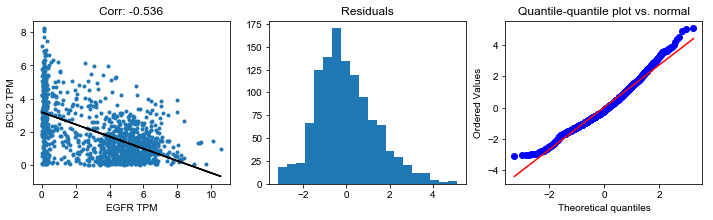

In [246]:
res1 = scatter(ccle_df, 'EGFR', ccle_df['BCL2'], 'BCL2 TPM', bins=20)

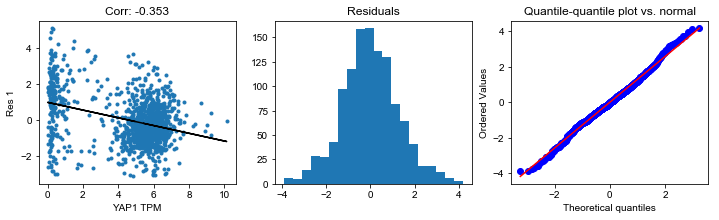

In [247]:
res2 = scatter(ccle_df, 'YAP1', res1, 'Res 1', bins=20)

Next steps:
1. load the INDRA SIF statement file
2. tabulate explanations for correlations;
3. predict correlations from graph structure, edge properties

# Load INDRA SIF DB

In [16]:
stmts_df = pd.read_csv('data/stmts_by_pair_type.csv')
# Filter to HGNC only
stmts_df = stmts_df[(stmts_df['agA_ns'] == 'HGNC') & (stmts_df['agB_ns'] == 'HGNC')]
# Remove namespace and identifier columns, leaving only name
stmts_df = stmts_df[['agA_name', 'agB_name', 'stmt_type', 'evidence_count']]
# Remove self-edges
stmts_df = stmts_df[stmts_df['agA_name'] != stmts_df['agB_name']]
# Useful bits of Pandas to know, ultimately not used here:
# pd.crosstab([foo['agA_name'], foo['agB_name']], foo['stmt_type'], foo['evidence_count'],
#             aggfunc='sum', dropna=False).fillna(0)
# baz = bar[bar.apply(lambda x: x.name[0] != x.name[1], axis=1)]

/Users/johnbachman/.virtualenvs/p36env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [17]:
x_dict = {}
for row in stmts_df.values:
    try:
        raw_corr = dep_z[row[0]][row[1]]
        """
        if int(raw_corr) == 0:
            corr = 0
        elif int(raw_corr) < 0:
            corr = -1
        elif int(raw_corr) > 0:
            corr = 1
        """
        corr = raw_corr
    except KeyError:
        continue
    stmt_type = row[2]
    gene_pair = (row[0], row[1])
    if gene_pair not in x_dict:
        x_dict[gene_pair] = {'Corr': corr}
    x_dict[gene_pair][stmt_type] = row[3]
features = ['Activation', 'Inhibition', 'Corr']
all_data = np.zeros((len(x_dict), len(features)))
for row_ix, feat_dict in enumerate(x_dict.values()):
    for feat_name, feat_val in feat_dict.items():
        if feat_name not in features:
            continue
        feat_ix = features.index(feat_name)
        all_data[row_ix, feat_ix] = feat_val

In [18]:
"""
# Shuffle the matrix in place
np.random.shuffle(all_data)
# Balance the data
ctr = Counter(all_data[:, -1])
classes = sorted([(k, v) for k,  v in ctr.items()], key=lambda x: x[0])
# Get the class with the fewest members
min_class_count = min([t[1] for t in classes])
min_class_count
data_bal = np.zeros((min_class_count * len(classes), len(features)))
row_ix = 0
for one_class, count in classes:
    num_class_rows = 0
    for ix in range(all_data.shape[0]):
        if all_data[ix, -1] == one_class:
            data_bal[row_ix] = all_data[ix,:]
            row_ix += 1
            num_class_rows += 1
        if num_class_rows >= min_class_count:
            print("Finished class %s, at rows %s" % (one_class, row_ix))
            break

"""

'\n# Shuffle the matrix in place\nnp.random.shuffle(all_data)\n# Balance the data\nctr = Counter(all_data[:, -1])\nclasses = sorted([(k, v) for k,  v in ctr.items()], key=lambda x: x[0])\n# Get the class with the fewest members\nmin_class_count = min([t[1] for t in classes])\nmin_class_count\ndata_bal = np.zeros((min_class_count * len(classes), len(features)))\nrow_ix = 0\nfor one_class, count in classes:\n    num_class_rows = 0\n    for ix in range(all_data.shape[0]):\n        if all_data[ix, -1] == one_class:\n            data_bal[row_ix] = all_data[ix,:]\n            row_ix += 1\n            num_class_rows += 1\n        if num_class_rows >= min_class_count:\n            print("Finished class %s, at rows %s" % (one_class, row_ix))\n            break\n\n'

In [18]:
# Divide training and test
np.random.shuffle(all_data)
partition_ix = int(len(all_data) * 0.8)
train_data = all_data[0:partition_ix, :]
test_data = all_data[partition_ix:, :]
x_train = train_data[:,:-1]
y_train = train_data[:, -1]
x_test = test_data[:, :-1]
y_test = test_data[:, -1]

## Multinomial Naive Bayes

In [21]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(x_train, y_train)
nb.score(x_test, y_test)

ValueError: Unknown label type: (array([-0.05516979,  0.14065217, -1.34013057, ...,  0.64655844,
        0.26385124, -0.2254322 ]),)

In [212]:
yctr = Counter(y_train)
yclasses = sorted([(k, v) for k,  v in yctr.items()], key=lambda x: x[0])

In [213]:
[features + ['Count']] + list(zip(nb.coef_, classes))

[['Activation', 'Inhibition', 'Corr', 'Count'],
 (array([-0.4361943 , -1.03984945]), (-1.0, 34057)),
 (array([-0.33757549, -1.25001014]), (0.0, 445943)),
 (array([-0.34648099, -1.22817076]), (1.0, 49708))]

## Linear Regression

In [66]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score
from sklearn.kernel_ridge import KernelRidge
lr = LinearRegression()

In [59]:
lr.fit(x_train, y_train)
lr.coef_

array([ 0.00083149, -0.00308015])

In [60]:
y_pred = lr.predict(x_train)
explained_variance_score(y_train, y_pred)

0.0005353616554718554

In [64]:
y_mean = np.full(y_train.shape, y_train.mean())
explained_variance_score(y_train, y_mean)

0.0

In [65]:
y_pred_test = lr.predict(x_test)
explained_variance_score(y_test, y_pred_test)

0.00023949117530219777

# Load INDRA Statements (deprecated)

In [ ]:
reload = False
if reload:
    inc_stmts = ac.load_statements('increase_amt.pkl')
    dec_stmts = ac.load_statements('decrease_amt.pkl')
    stmts = inc_stmts + dec_stmts
    stmts = ac.map_grounding(stmts)
    stmts = [s for s in stmts if s.subj and s.subj.db_refs.get('HGNC')
                             and s.obj and s.obj.db_refs.get('HGNC')]
    stmts = ac.run_preassembly(stmts)
    ac.dump_statements(stmts, 'assembled_stmts.pkl')
else:
    stmts = ac.load_statements('assembled_stmts.pkl')

In [ ]:
stmts_by_obj = defaultdict(list)
for s in stmts:
    gene_id = s.obj.db_refs['HGNC']
    gene_name = hgnc_client.get_hgnc_name(gene_id)
    stmts_by_obj[gene_name].append(s)

In [ ]:
stmt_counts = []
for obj, stmts in stmts_by_obj.items():
    stmt_counts.append((obj, len(stmts)))
stmt_counts.sort(key=lambda x: x[1], reverse=True)

In [ ]:
stmt_counts[0:10]

In [ ]:
gene = 'BCL2'
rank = 0
stmts_by_obj[gene].sort(key=lambda s: s.belief, reverse=True)
print(stmts_by_obj[gene][rank], '\n')
print('\n'.join(['%d: %s\n' % (i, str((e.source_api, e.text)))
                 for i, e in enumerate(stmts_by_obj[gene][rank].evidence)]))